# 安装

## 安装命令
```bash
conda create -n cloudnetpy python==3.11 -c conda-forge 
conda install timezonefinder -c conda-forge -y
pip3 install cloudnetpy
```
## bug修复
以下代码已经合并至最新版 cloudnetpy 和 ceilopyter 中，安装最新版本不需要进行下面的修复工作。

`D:\Programs\miniforge3\envs\cloudnetpy\Lib\site-packages\cloudnetpy\instruments\vaisala.py `修改如下代码
```
# ...existing code...
    def _screen_time_indices(
        self, valid_indices: npt.NDArray[np.intp] | npt.NDArray[np.bool_]
    ) -> None:
        time = self.data["time"]
        n_time = len(time)
        if len(valid_indices) == 0 or (
            valid_indices.dtype == np.bool_ and not np.any(valid_indices)
        ):
            msg = "All timestamps screened"
            raise ValidTimeStampError(msg)
        for key, array in self.data.items():
            if hasattr(array, "shape") and array.shape[:1] == (n_time,):
                self.data[key] = self.data[key][valid_indices]
# ...existing code...
```
`D:\Programs\miniforge3\envs\cloudnetpy\Lib\site-packages\ceilopyter\noise.py`改为如下代码
```
import numpy as np
import numpy.typing as npt
from numpy import ma


def remove_noise(
    beta_uncorr: npt.NDArray[np.floating], noise_floor: float, snr_limit: float = 5
) -> npt.NDArray[np.bool_]:
    zero_ranges = np.all(beta_uncorr == 0, axis=0)
    n_zeros = np.argmax(~zero_ranges[::-1])

    fraction = 0.1
    n_top_gates = round(beta_uncorr.shape[1] * fraction)
    beta_top = beta_uncorr[:, -n_top_gates - n_zeros : -n_zeros]
    noise = ma.std(beta_top, axis=1)

    noise = np.maximum(noise, noise_floor)
    snr = beta_uncorr / noise[:, np.newaxis]

    is_noise = snr < snr_limit

    return is_noise

```


# 快速入门
本教程使用 CloudnetPy 的高级 API 从原始数据创建产品。

原始数据转换
在生成 Cloudnet 产品之前，我们需要将原始仪器数据转换为 Cloudnet Level 1b netCDF 文件。让我们从慕尼黑站点的以下原始文件开始：

METEK MIRA 云雷达：20230729_0000.mmclx.gz（使用前请解压缩）

卢夫特 CHM 15k 云高仪：CHM15kxLMU_20230729.nc

RPG HATPRO 微波辐射计：230729.LWP

欧洲中期天气预报中心模型：20230729_munich_ecmwf.nc

在Linux和macOS系统上，可以使用以下命令下载这些文件：

```
curl -O https://cloudnet.fmi.fi/api/download/raw/62905a7c-4e18-474f-8532-bb59f39ca4ff/20230729_0000.mmclx.gz
gunzip 20230729_0000.mmclx.gz
curl -O https://cloudnet.fmi.fi/api/download/raw/7d1909f3-c73f-4de9-a771-e6795751e495/CHM15kxLMU_20230729.nc
curl -O https://cloudnet.fmi.fi/api/download/raw/490704b2-7533-4137-979b-f197a6c72e17/230729.LWP
curl -O https://cloudnet.fmi.fi/api/download/product/856b5a84-155b-427d-b914-09238c206c02/20230729_munich_ecmwf.nc
```

In [1]:
import numpy as np
import xarray as xr
from datetime import datetime,timedelta

In [2]:
datapath='../Datas/CloundNetPy/'

In [3]:
import cloudnetpy

In [4]:
cloudnetpy.__version__

'1.86.9'

In [5]:
np.__version__

'1.26.0'

In [6]:
import ceilopyter 

## 雷达处理
在第一个示例中，我们将原始的 METEK MIRA-36 云雷达文件转换为 Cloudnet netCDF 文件，以便在后续处理步骤中使用。

In [7]:
from cloudnetpy.instruments import mira2nc
uuid = mira2nc(datapath+'20230729_0000.mmclx', datapath+'radar.nc', {'name': 'Munich'})

该变量uuid包含生成文件的唯一标识符radar.nc。更多信息，请参阅此函数的API 参考文档。

您可以绘制新生成文件中的雷达反射率因子等变量。

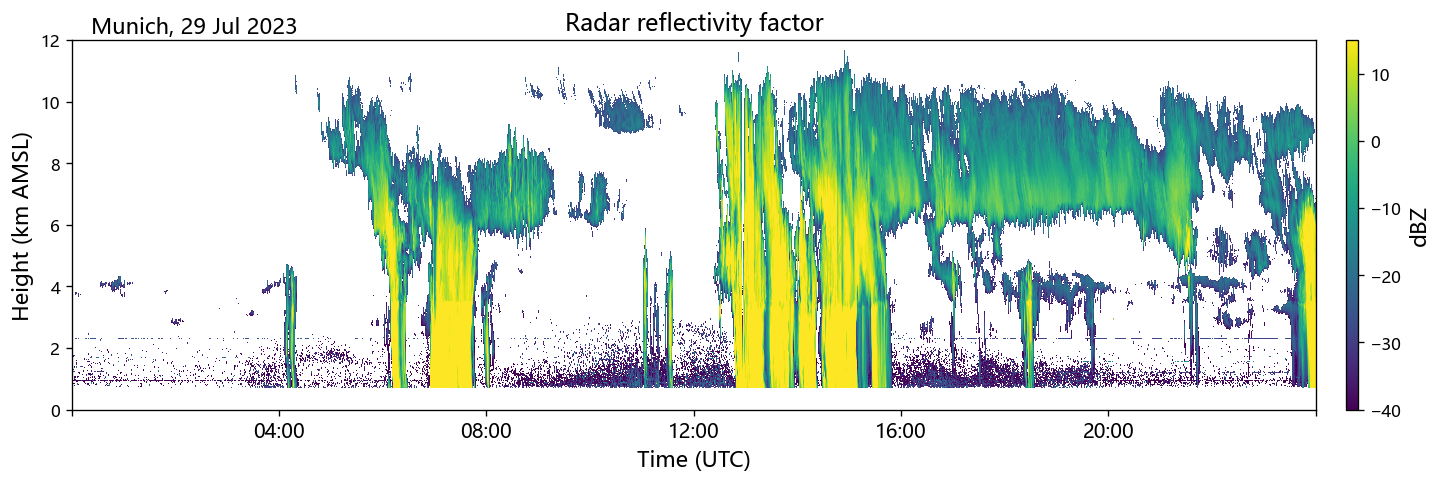

In [10]:
from cloudnetpy.plotting import generate_figure
generate_figure(datapath+'radar.nc', ['Zh'])

In [11]:
radards=xr.open_dataset(datapath+'radar.nc')

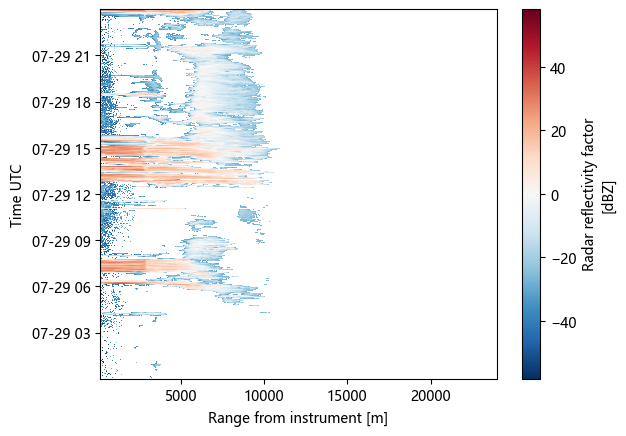

In [12]:
radards['Zh'].plot()

## 激光雷达处理
接下来，我们将原始的 Lufft CHM 15k 云高仪（激光雷达）文件转换为 Cloudnet netCDF 文件，并处理信噪比筛选后的后向散射系数。转换后的激光雷达文件稍后也会用到。

In [16]:
from cloudnetpy.instruments import ceilo2nc
uuid = ceilo2nc(datapath+'CHM15kxLMU_20230729.nc', datapath+'lidar.nc', {'name': 'Munich', 'altitude': 538})

该变量uuid包含生成文件的唯一标识符lidar.nc。更多信息，请参阅此函数的API 参考文档。

您可以绘制新生成的文件中的变量，例如衰减后向散射系数。

D:\Programs\miniforge3\envs\cloudnetpy\Lib\site-packages\matplotlib\colors.py:778: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


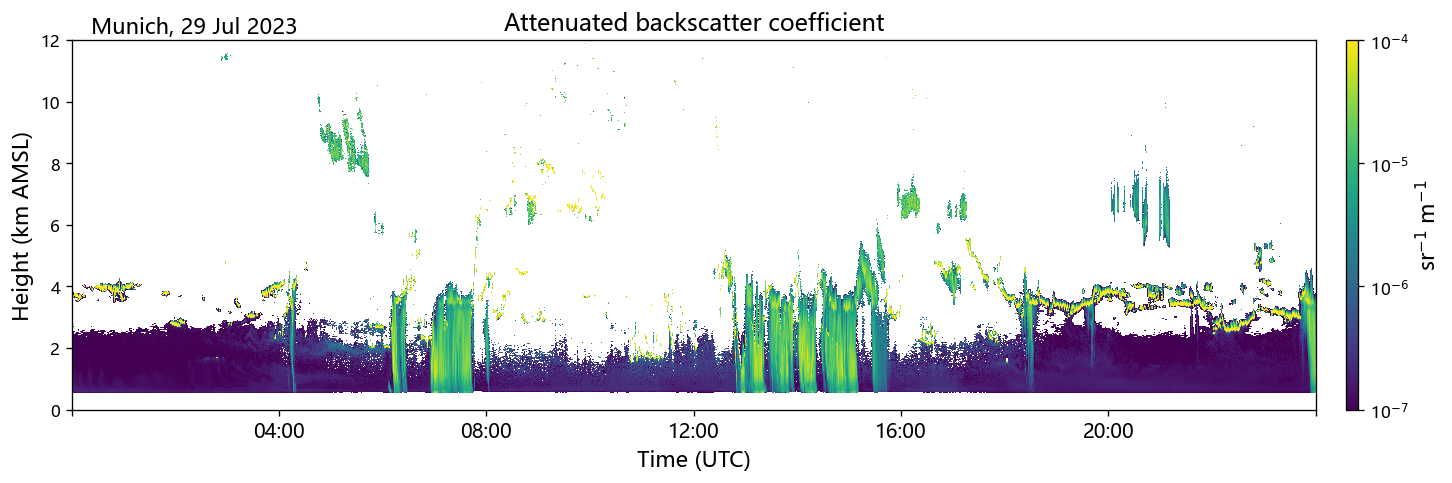

In [18]:
generate_figure(datapath+'lidar.nc', ['beta'])

## MWR处理
接下来，我们将 RPG-HATPRO 微波辐射计 (MWR) 二进制文件（例如 *.LWP）转换为 Cloudnet netCDF 文件，以检索集成液态水路径 (LWP)。

In [20]:
from cloudnetpy.instruments import hatpro2nc
uuid, valid_files = hatpro2nc(datapath, datapath+'mwr.nc', {'name': 'Munich', 'altitude': 538}, date='2023-07-29')

该变量uuid包含生成文件的唯一标识符mwr.nc，而valid_files则包含用于处理的文件列表。更多信息，请参阅此函数的API 参考文档。

您可以绘制新生成的文件中的变量，例如液态水路径。

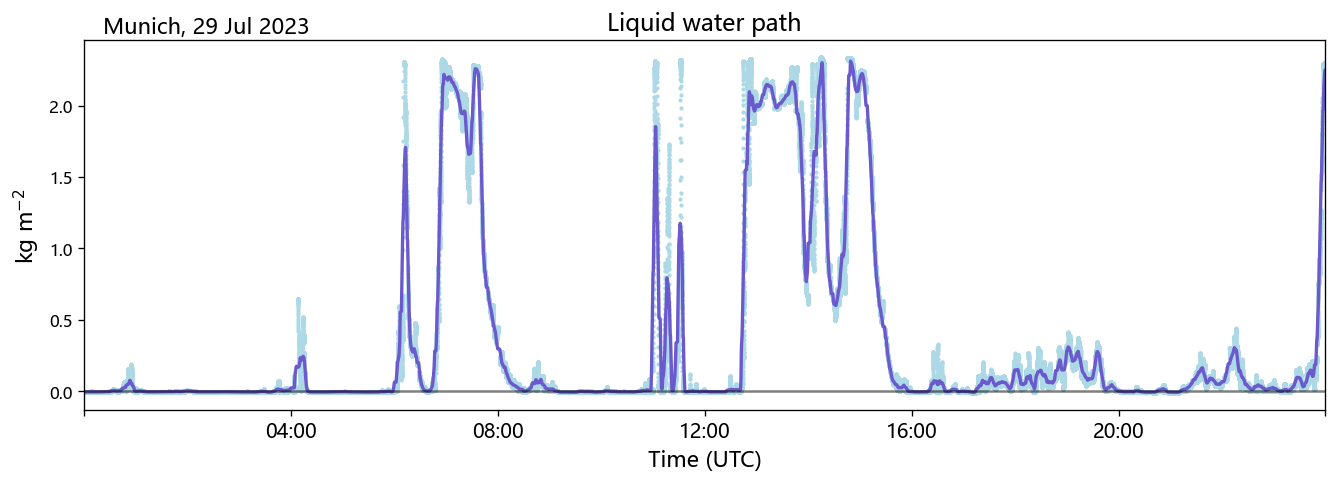

In [22]:
generate_figure(datapath+'mwr.nc', ['lwp'])

## 注意

如果您拥有94 GHz RPG云雷达，则无需单独的微波辐射计（MWR）。RPG雷达包含一个MWR通道，可提供液态水路径（LWP）测量数据，这些数据可用于CloudnetPy。尽管如此，我们始终建议尽可能为测量站点配备专用的多通道辐射计。

## 模型数据
下一处理步骤所需的模型文件可从Cloudnet 数据门户 API下载。根据站点和日期，可能有多个模型可用。不同模型的列表可在此处找到。

您可以绘制模型文件中的云量等变量。

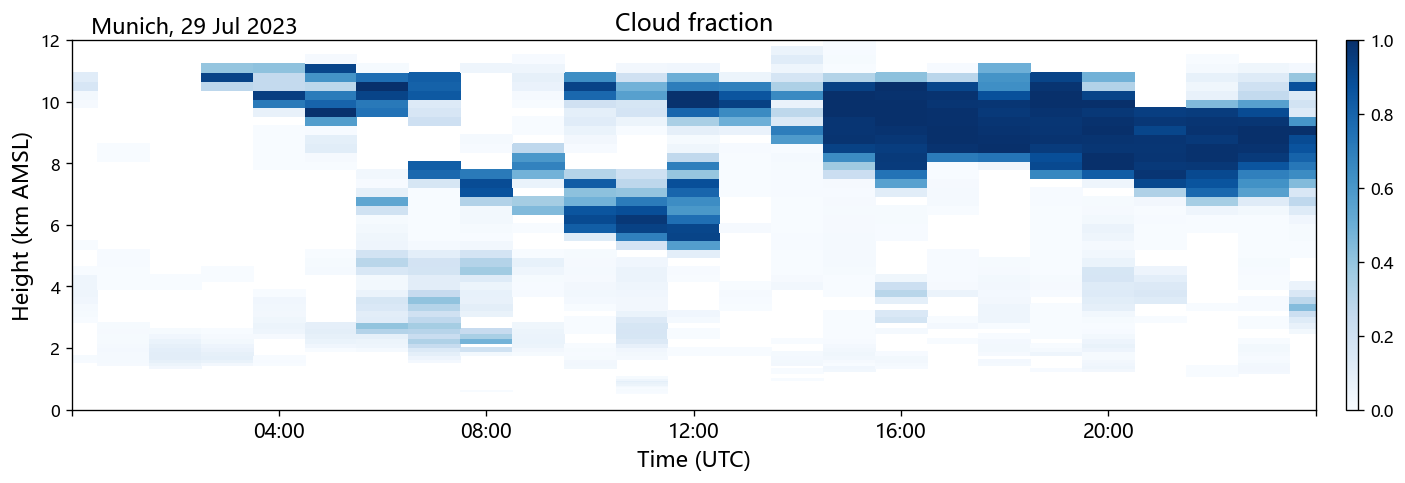

In [23]:
generate_figure(datapath+'20230729_munich_ecmwf.nc', ['cloud_fraction'])

## 产品生成
处理完原始雷达、激光雷达和MWR文件并获取模型文件后，即可创建Cloudnet产品。

## 对处理进行分类
在下一个示例中，我们将基于上面生成的文件创建一个分类文件 。radar.nc所需文件 可从本页顶部下载。mwr.nclidar.nc20230729_munich_ecmwf.nc

In [24]:
from cloudnetpy.categorize import generate_categorize
input_files = {
    'radar': datapath+'radar.nc',
    'lidar': datapath+'lidar.nc',
    'model': datapath+'20230729_munich_ecmwf.nc',
    'mwr': datapath+'mwr.nc'
}
uuid = generate_categorize(input_files, datapath+'categorize.nc')

该变量uuid包含生成文件的唯一标识符categorize.nc。有关更多信息，请参阅此函数的API 参考。请注意，对于 94 GHz RPG 云雷达，该radar.nc文件可用作两个输入的输入：'radar'和'mwr'。

## 分类处理
在最后一个示例中，我们创建了最小最简单的 Cloudnet 产品——分类产品。产品生成函数始终使用分类文件作为输入。

In [25]:
from cloudnetpy.products import generate_classification
uuid = generate_classification(datapath+'categorize.nc', datapath+'classification.nc')

该变量uuid包含生成文件的唯一标识符classification.nc。其他产品也有相应的函数（参见产品生成）。

您可以绘制新生成文件中的目标分类等变量。

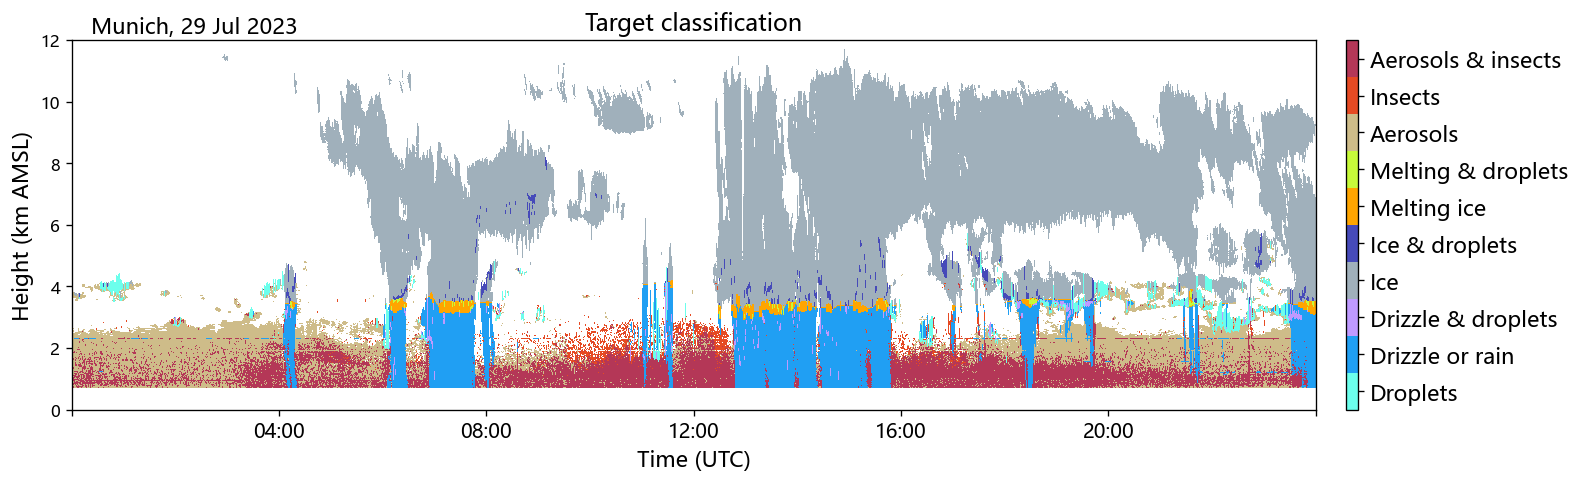

In [26]:
generate_figure(datapath+'classification.nc', ['target_classification'])